## Imports

In [56]:
#Python3.10
import pandas as pd 
import numpy as np
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt

from dateutil import relativedelta
from datetime import datetime
from shapely.geometry import Point

from dataretrieval import nwis, utils, codes

# TODO: Look into the warning that this is disabling. It doesn't appear to be significant for the purposes of this code but it needs to be understood
pd.options.mode.chained_assignment = None
#pd.options.mode.chained_assignment = 'warn'

## Classes

In [57]:
class StreamGauge:
    def __init__(self, id, name, mean_start_date, mean_end_date, post_start_date, post_end_date):
        self.id = id
        self.name = name
        # Start date for all-time mean daily flow data
        self.mean_start_date = mean_start_date
        self.mean_end_date = mean_end_date
        # Start date for post-impairment mean daily flow data
        self.post_start_date = post_start_date
        self.post_end_date = post_end_date 
        
    def get_id(self):
        """Return stream gauge USGS ID"""
        return self.id  
    
    def get_name(self):
        return self.name     
        
    def get_mean_date_range(self):
        """Return a time delta object between the start and end of the full record of streamflow data"""
        start_date = datetime.strptime(self.mean_start_date, "%Y-%m-%d")
        end_date = datetime.strptime(self.mean_end_date, "%Y-%m-%d")
        return relativedelta.relativedelta(end_date, start_date)
    
    def get_post_date_range(self):
        """Return a time delta object between the start and end of the post-impairment record of streamflow data"""
        start_date = datetime.strptime(self.post_start_date, "%Y-%m-%d")
        end_date = datetime.strptime(self.post_end_date, "%Y-%m-%d")
        return relativedelta.relativedelta(end_date, start_date)

## Inputs

In [167]:
# 11447650 -- Sacramento River Basin
# 11303500 -- San Joaquin-Tulare Basin
# SRB -- '1970-01-01' '2014-01-01'
# SJTB -- '1989-01-01' '2014-01-01'
# Water year -- Oct 1-Sept 30
        
SRB_Guage = StreamGauge('11447650', 'SACRAMENTO R A FREEPORT CA', '1948-10-01', '2014-09-30', '1970-10-01', '2014-09-30')
SJTB_Guage = StreamGauge('11303500', 'SAN JOAQUIN R NR VERNALIS CA', '1923-10-01', '2014-09-30', '1989-10-01', '2014-09-30')

# Change this to modify analysis values
curr_guage = SRB_Guage

SORT_BY_WB = True

QUANTILE = 0.90
STATE_CODE = 'CA'
HYDRO_YEAR = 'AS-OCT'
SERVICE = 'dv'
MIN_DATA_PERIOD = 30

# 00060 -- Discharge
# 00010 -- Temperature
PARAM_CODE = '00060'

# Site ID URI
SITES_URI = f'https://waterdata.usgs.gov/{STATE_CODE}/nwis/current?index_pmcode_STATION_NM=1&index_pmcode_DATETIME=2&index_pmcode_{PARAM_CODE}=3&group_key=NONE&format=sitefile_output&sitefile_output_format=rdb&column_name=site_no&column_name=station_nm&column_name=dec_lat_va&column_name=dec_long_va&column_name=sv_begin_date&column_name=sv_end_date&sort_key_2=site_no&html_table_group_key=NONE&rdb_compression=file&list_of_search_criteria=realtime_parameter_selection'

## Functions

In [59]:
# CONSTANTS
SEC_PER_DAY = 86400
CUBIC_FT_KM_FACTOR = 0.0000000000283168466

# FUNCTIONS
def calc_threshold(df: pd.DataFrame, value: float):
    """Returns a threshold above which flow is considered HMF given flow values and a threshold 0 < t < 1""" 
    df = pd.DataFrame(df['00060_Mean'])
    return df.quantile(q=value, axis=0).iloc[0]

def filter_hmf(df: pd.DataFrame, threshold: float):
    """Returns a dataframe with only flow values above a given threshold present"""
    return df[df['00060_Mean'] > threshold]

def convert_hmf(df: pd.DataFrame, threshold: float):
    """Converts flow values from ft^3/s to ft^3/day and returns only excess flow above a given threshold"""
    return (df['00060_Mean'] - threshold) * SEC_PER_DAY

def num_hmf_years(df: pd.DataFrame, offset: int):
    """Returns the integer number of HMF years, using an offset to indicate the start of the Hydrologic Year (i.e. 10 = October)"""
    df.loc[:, 'datetime'] = pd.to_datetime(df['datetime'])
    df.set_index('datetime', inplace=True)    
    df.loc[:, 'offsetdate'] = (df.index - pd.offsets.YearBegin(month=offset))    
    return df['offsetdate'].dt.year.nunique()

def three_six_range(df: pd.DataFrame, three_start: int, three_end: int, six_start: int, six_end: int):
    """Returns two dataframes, one with a six month period, and one with a three month period, based on given start and end months for both"""
    df = df.reset_index()
    df.loc[:, 'datetime'] = pd.to_datetime(df['datetime'])    
    six_month_mask = (df['datetime'].dt.month >= six_start) | (df['datetime'].dt.month <= six_end)
    three_month_mask = (df['datetime'].dt.month >= three_start) | (df['datetime'].dt.month <= three_end)
    return df[six_month_mask], df[three_month_mask]

def calc_duration(df: pd.DataFrame):
    """Returns the total number of HMF days over the dataframes time period"""
    df.loc[:, 'datetime'] = pd.to_datetime(df['datetime'])
    df.set_index('datetime', inplace=True)  
    df_results = df.resample(HYDRO_YEAR).agg({'00060_Mean': ['count']})
    df_results.columns = ['Count']
    return df_results['Count'].sum()
    
def convert_cubic_ft_hm(value: float):
    """Convert ft^3 to km^3"""
    return value * CUBIC_FT_KM_FACTOR
    

## Single Site Data<br>

In [90]:
# df2 holds all-time data, df is analyzed range
df = nwis.get_record(sites=curr_guage.id, service=SERVICE, parameterCD=PARAM_CODE, start=curr_guage.mean_start_date, end=curr_guage.mean_end_date)
df2 = nwis.get_record(sites=curr_guage.id, service=SERVICE, parameterCD=PARAM_CODE, start=curr_guage.mean_start_date, end=curr_guage.mean_end_date)

# If looking at a post impairment period, but calculating threshold based on the full record of data, pass a second dataframe with a different 
# start/end date as df2, otherwise pass df twice
def single_site_data(df: pd.DataFrame, df2: pd.DataFrame):
    df = df.reset_index()
    df2 = df2.reset_index()
    #df2.to_csv('srb_full.csv')

    #print(f'Statistics for {curr_guage.get_name()}')

    # 90th percentile calculation
    threshold = calc_threshold(df2, QUANTILE)    

    # Create a dataframe with only days over HMF threshold 
    hmf_series = filter_hmf(df, threshold)

    # Find number of years with HMF 
    hmf_years = num_hmf_years(hmf_series, 10)    

    # Mask out months that don't fall within 3 and 6 month Winter range
    df_six_month, df_three_month = three_six_range(hmf_series, 12, 2, 11, 4)

    # Convert to daily average flow in cfps, and take only flow above the threshold
    hmf_series = convert_hmf(hmf_series, threshold)
    total_hmf_flow = hmf_series.sum()
    #print(f'Total Volume of HMF: {total_hmf_flow}')

    # Calculate 3 and 6 month HMF
    df_six_month = convert_hmf(df_six_month, threshold)
    six_month_hmf = df_six_month.sum()
    df_three_month = convert_hmf(df_three_month, threshold)
    three_month_hmf = df_three_month.sum()

    # Inter-annual and Duration Calculation (across the full record)
    hmf_series_full = filter_hmf(df2, threshold)
    hmf_years_full = num_hmf_years(hmf_series_full, 10)

    delta = curr_guage.get_mean_date_range()
    inter_annual = (hmf_years_full / (delta.years + 1)) * 100

    # Average Duration
    hmf_series_dur = filter_hmf(df, threshold)
    hmf_series_dur = pd.DataFrame(hmf_series_dur)
    duration = calc_duration(hmf_series_dur)
    avg_duration = duration / hmf_years
    
    total_hmf_flow = (total_hmf_flow * CUBIC_FT_KM_FACTOR) / hmf_years
    six_month_hmf = (six_month_hmf * CUBIC_FT_KM_FACTOR) / hmf_years
    three_month_hmf = (three_month_hmf * CUBIC_FT_KM_FACTOR) / hmf_years
    
    return avg_duration, inter_annual, total_hmf_flow, six_month_hmf, three_month_hmf, hmf_years, threshold

avg_duration, inter_annual, total_hmf_flow, six_month_hmf, three_month_hmf, hmf_years, threshold = single_site_data(df, df2)

def single_site_report(avg_duration, inter_annual, total_hmf_flow, six_month_hmf, three_month_hmf, hmf_years, threshold):
    print(f'90%: {threshold}')
    print(f'HMF Years: {hmf_years}')
    print(f'Average Duration: {avg_duration:.1f}')
    print(f'Inter-annual Frequency: {inter_annual:.1f}%')
    print(f'Total HMF in km^3/year: {total_hmf_flow:.1f}')
    print(f'6 Month HMF in km^3/year: {six_month_hmf:.1f}')
    print(f'3 Month HMF in km^3/year: {three_month_hmf:.1f}')
    
single_site_report(avg_duration, inter_annual, total_hmf_flow, six_month_hmf, three_month_hmf, hmf_years, threshold)


90%: 52350.0
HMF Years: 47
Average Duration: 51.3
Inter-annual Frequency: 71.2%
Total HMF in km^3/year: 2.1
6 Month HMF in km^3/year: 2.0
3 Month HMF in km^3/year: 1.3


## Multi-Site Data<br>

In [174]:
import requests
from io import StringIO

shapefile_path = f'ShapeFiles/{STATE_CODE}/Central/South_Central/WBDHU12.shp'

# Request page from USGS site, ignore all informational lines
response = requests.get(SITES_URI)
data = response.text
lines = data.splitlines()
lines = [line for line in lines if not line.startswith('#')]

# Create dataframe where site_no is a list of all sites in a state with 00060 data
tsd = "\n".join(lines)
df = pd.read_csv(StringIO(tsd), sep='\t')
df_state_sites = df.iloc[1:]

# Filter out sites with <30 years of data
df_state_sites['sv_begin_date'] = pd.to_datetime(df_state_sites['sv_begin_date'])
df_state_sites['sv_end_date'] = pd.to_datetime(df_state_sites['sv_end_date'])
df_state_sites['data_period'] = (df_state_sites['sv_end_date'] - df_state_sites['sv_begin_date']).dt.days / 365.25
df_state_sites = df_state_sites[df_state_sites['data_period'] >= MIN_DATA_PERIOD]

# Filter out sites outside of HU boundary
if SORT_BY_WB:
    shapefile = gpd.read_file(shapefile_path)
    df_state_sites['geometry'] = [Point(lon, lat) for lon, lat in zip(df_state_sites['dec_long_va'], df_state_sites['dec_lat_va'])]
    gdf_data = gpd.GeoDataFrame(df_state_sites, crs=shapefile.crs)
    df_state_sites = gpd.sjoin(gdf_data, shapefile, predicate='within')

print(f'Total Sites: {len(df_state_sites)} in the state of {STATE_CODE.upper()} in the given WB')

site_list = df_state_sites['site_no'].to_list()
print(site_list)
#print(df_state_sites.columns.to_list())
#print(df_state_sites)


Total Sites: 25 in the state of CA in the given WB
['11251000', '11261100', '11261500', '11262900', '11264500', '11266500', '11274000', '11274500', '11274630', '11276500', '11276600', '11276900', '11277300', '11278300', '11278400', '11278000', '11284400', '11289000', '11289500', '11289650', '11290000', '11299600', '11303000', '11303500', '11335000']


In [175]:
# Used for now to limit runtime
SITE_LIMIT = 999

# Necessary for proper iterrows() behavior
df_state_sites.reset_index(drop=True, inplace=True)

# Creating the dataframe that will hold final results for mapping
columns = ['site_no', 'threshold', 'hmf_per_year', 'avg_duration', 'inter_annual', 'six_month_hmf', 'three_month_hmf', 'hmf_years','dec_lat_va', 'dec_long_va']
df_multi_site = pd.DataFrame(columns=columns)

for index, row in df_state_sites.iterrows():
    while index < SITE_LIMIT:
        # Date converstion for use with dataretrieval (doesn't behave with HH:MM:SS)
        ts_obj = pd.to_datetime(row['sv_begin_date'])
        start = str(ts_obj.date())
        ts_obj = pd.to_datetime(row['sv_end_date'])
        end = str(ts_obj.date())

        # Create a dataframe for the current site in the iteration to perform calculations on
        df = nwis.get_record(sites=row['site_no'], service=SERVICE, parameterCD=PARAM_CODE, start=start, end=end)
        
        #df = nwis.get_record(sites='11447650', service=SERVICE, parameterCD=PARAM_CODE, start='1948-10-01', end='2014-09-30')
        avg_duration, inter_annual, total_hmf_flow, six_month_hmf, three_month_hmf, hmf_years, threshold = single_site_data(df, df)
        #single_site_report(avg_duration, inter_annual, total_hmf_flow, six_month_hmf, three_month_hmf, hmf_years)
        #print(df)
        
        data = {'site_no': row['site_no'], 'threshold': threshold, 'hmf_per_year': total_hmf_flow, 'avg_duration': avg_duration, 
                'inter_annual': inter_annual, 'six_month_hmf': six_month_hmf, 'three_month_hmf': three_month_hmf, 
                'hmf_years': hmf_years, 'dec_lat_va': row['dec_lat_va'], 'dec_long_va': row['dec_long_va']}
        
        data = pd.DataFrame(data, index=['0'])

        df_multi_site = pd.concat([df_multi_site, data], ignore_index=True)       
        break

#print(df_multi_site)
print(f'Max HMF for this region: {df_multi_site["hmf_per_year"].max():.1f}')

Max HMF for this region: 2.2


## Mapping<br>

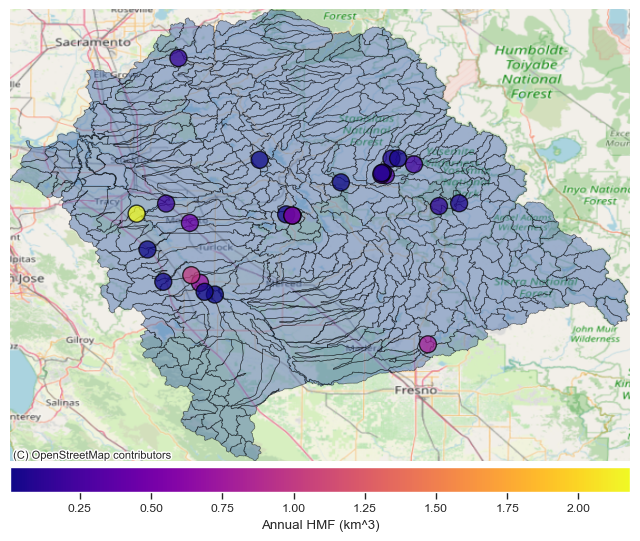

In [190]:
import contextily as cx
from sklearn.preprocessing import MinMaxScaler
import matplotlib.colors as mcolors

shape = gpd.read_file(shapefile_path)
#print(shape.crs)

#df = nwis.get_record(sites=SITE_NO, service='site')
#df2 = nwis.get_record(sites='11303500', service='site')
lat = df_multi_site['dec_lat_va'].tolist()
long = df_multi_site['dec_long_va'].tolist()

fig, ax = plt.subplots(figsize=(8, 8))
ax.margins(0)

# This plots the WB shapefile region
shape.plot(ax=ax, alpha=0.50, edgecolor='black', linewidth=0.5)

geometry = [Point(xy) for xy in zip(long, lat)]
geo_df = gpd.GeoDataFrame(geometry=geometry)

# Set colorbar limits and theme
vmin = df_multi_site['hmf_per_year'].min()
vmax = df_multi_site['hmf_per_year'].max()
norm = mcolors.Normalize(vmin, vmax)
cmap = 'plasma'
mappable = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
mappable.set_array(df_multi_site['hmf_per_year'])


# This plots the datapoints
bx = geo_df.plot(ax=ax, column=df_multi_site['hmf_per_year'], markersize=600, marker='.', cmap=cmap, edgecolor='black', linewidth=1, alpha=0.75)
cbx = plt.colorbar(mappable, ax=bx, pad=0.01, aspect=25, orientation='horizontal', alpha=1.0)
cbx.set_label('Annual HMF (km^3)')

#bx.set_title("WBDHU8")
bx.margins(0, tight=True)
bx.set_axis_off()

# This plots the context backmap
cx.add_basemap(bx, crs=shape.crs, source=cx.providers.OpenStreetMap.Mapnik, zoom=8)

## Data Visualization<br>

Rows: 47
Correlation: 0.6181660900296607


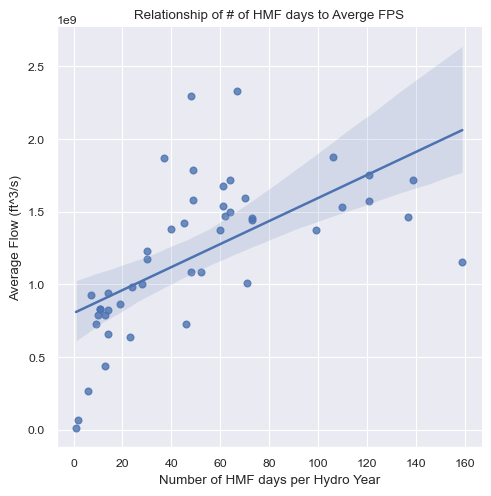

Rows: 39
Correlation w/No Outliers: 0.7340109778858692


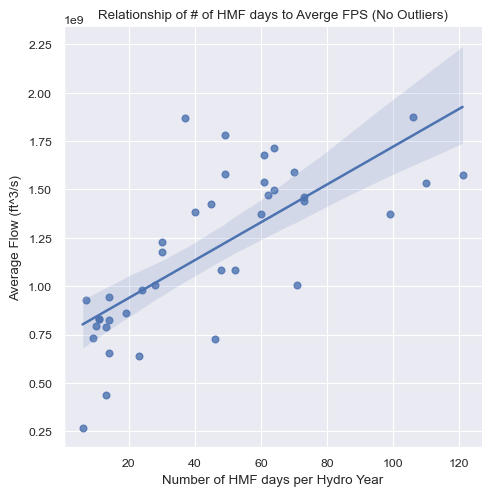

In [179]:
# Scatter plot looking at correlation between # of HMF days per hydrologic year, and average daily flow 
df = nwis.get_record(sites=curr_guage.id, service=SERVICE, parameterCD=PARAM_CODE, start=curr_guage.mean_start_date, end=curr_guage.mean_end_date)
threshold = calc_threshold(df, QUANTILE)
hmf_series = filter_hmf(df, threshold)
hmf_series = convert_hmf(hmf_series, threshold)
#hmf_series.to_csv('hmf_series.csv')
hmf_series = pd.DataFrame(hmf_series)
#hmf_series.set_index('datetime', inplace=True)

# Aggregate dataframe by total flow per day per hydro year, and # of HMF days per hydro year
df_results = hmf_series.resample(HYDRO_YEAR).agg({'00060_Mean': ['sum', 'count']})
df_results.columns = ['Sum', 'Count']
#print(df_results)

# Remove all hydrologic years with no HMF and calculate average FPS/per day
df_results = df_results[df_results['Count'] != 0]
df_results['Average FPS'] = df_results['Sum'] / df_results['Count']
print(f'Rows: {len(df_results)}')

# Correlation
corr = df_results['Count'].corr(df_results['Average FPS'])
print(f'Correlation: {corr}')

# Data Plotting

#plt.figure(figsize=(6, 6))
sns.set(color_codes=True)
sns.set_context('paper')

sns.lmplot(data=df_results, x='Count', y='Average FPS')
plt.xlabel('Number of HMF days per Hydro Year')
plt.ylabel('Average Flow (ft^3/s)')
plt.title('Relationship of # of HMF days to Averge FPS')
plt.show()

# Remove outliers w/Z-score
z_scores = np.abs((df_results - df_results.mean()) / df_results.std())
#print(z_scores)

# Somewhat arbitrary threshold that removes just the most egregious outliers
threshold = 2
df_results_no = df_results[(z_scores <= threshold).all(axis=1)]

print(f'Rows: {len(df_results_no)}')
# Correlation no outliers
corr_no = df_results_no['Count'].corr(df_results_no['Average FPS'])
print(f'Correlation w/No Outliers: {corr_no}')

#plt.figure(figsize=(6, 6))
sns.lmplot(data=df_results_no, x='Count', y='Average FPS')
plt.xlabel('Number of HMF days per Hydro Year')
plt.ylabel('Average Flow (ft^3/s)')
plt.title('Relationship of # of HMF days to Averge FPS (No Outliers)')
plt.show()